In [1]:

from importlib import reload
import os
import pandas as pd
from io import StringIO
import itertools
import ipdb
import datetime
from collections import Counter

import h5py
import json
import tensorflow as tf
from tensorflow import keras

# Helper libraries
import numpy as np
import matplotlib.pyplot as plt

print(tf.__version__)

from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import Dense, Embedding
from keras.layers import LSTM

from keras.callbacks import EarlyStopping

from sklearn.preprocessing import StandardScaler

import mytf.s3utils as msu
import mytf.utils as mu
import mytf.plot as mp

1.14.0


Using TensorFlow backend.


In [2]:
os.getpid()

23574

In [3]:
tf.enable_eager_execution()


In [5]:
with h5py.File('data/test.h5', 'r+') as fd:
    print(list(fd.keys()))


['dataset_0_X', 'dataset_0_Y', 'dataset_10_X', 'dataset_10_Y', 'dataset_11_X', 'dataset_11_Y', 'dataset_12_X', 'dataset_12_Y', 'dataset_13_X', 'dataset_13_Y', 'dataset_14_X', 'dataset_14_Y', 'dataset_15_X', 'dataset_15_Y', 'dataset_16_X', 'dataset_16_Y', 'dataset_17_X', 'dataset_17_Y', 'dataset_18_X', 'dataset_18_Y', 'dataset_19_X', 'dataset_19_Y', 'dataset_1_X', 'dataset_1_Y', 'dataset_20_X', 'dataset_20_Y', 'dataset_21_X', 'dataset_21_Y', 'dataset_22_X', 'dataset_22_Y', 'dataset_23_X', 'dataset_23_Y', 'dataset_24_X', 'dataset_24_Y', 'dataset_25_X', 'dataset_25_Y', 'dataset_26_X', 'dataset_26_Y', 'dataset_27_X', 'dataset_27_Y', 'dataset_28_X', 'dataset_28_Y', 'dataset_29_X', 'dataset_29_Y', 'dataset_2_X', 'dataset_2_Y', 'dataset_30_X', 'dataset_30_Y', 'dataset_31_X', 'dataset_31_Y', 'dataset_32_X', 'dataset_32_Y', 'dataset_33_X', 'dataset_33_Y', 'dataset_34_X', 'dataset_34_Y', 'dataset_35_X', 'dataset_35_Y', 'dataset_36_X', 'dataset_36_Y', 'dataset_37_X', 'dataset_37_Y', 'dataset_38_X

In [12]:
with h5py.File('data/train.h5', 'r+') as fd:
    print(list(fd.keys()))


['dataset_0_X', 'dataset_0_Y', 'dataset_10_X', 'dataset_10_Y', 'dataset_11_X', 'dataset_11_Y', 'dataset_12_X', 'dataset_12_Y', 'dataset_13_X', 'dataset_13_Y', 'dataset_14_X', 'dataset_14_Y', 'dataset_15_X', 'dataset_15_Y', 'dataset_16_X', 'dataset_16_Y', 'dataset_17_X', 'dataset_17_Y', 'dataset_18_X', 'dataset_18_Y', 'dataset_19_X', 'dataset_19_Y', 'dataset_1_X', 'dataset_1_Y', 'dataset_20_X', 'dataset_20_Y', 'dataset_21_X', 'dataset_21_Y', 'dataset_22_X', 'dataset_22_Y', 'dataset_23_X', 'dataset_23_Y', 'dataset_24_X', 'dataset_24_Y', 'dataset_25_X', 'dataset_25_Y', 'dataset_26_X', 'dataset_26_Y', 'dataset_27_X', 'dataset_27_Y', 'dataset_28_X', 'dataset_28_Y', 'dataset_29_X', 'dataset_29_Y', 'dataset_2_X', 'dataset_2_Y', 'dataset_30_X', 'dataset_30_Y', 'dataset_31_X', 'dataset_31_Y', 'dataset_32_X', 'dataset_32_Y', 'dataset_33_X', 'dataset_33_Y', 'dataset_34_X', 'dataset_34_Y', 'dataset_35_X', 'dataset_35_Y', 'dataset_36_X', 'dataset_36_Y', 'dataset_37_X', 'dataset_37_Y', 'dataset_38_X

In [7]:
with h5py.File('data/test.h5', 'r+') as fd:
    X1 = fd['dataset_0_X'].__array__()
    Y1 = fd['dataset_0_Y'].__array__()

In [8]:
Y1[:10]

Counter([np.argmax(Y1[i]) for i in range(Y1.shape[0])])

Counter({0: 117, 2: 9819})

In [4]:
for i in range(56):

    with h5py.File('data/test.h5', 'r+') as fd:
        X = fd[f'dataset_{i}_X'].__array__()
        Y = fd[f'dataset_{i}_Y'].__array__()
        
    

In [5]:
training_indices = np.arange(0, X.shape[0], 1)

In [6]:
len(training_indices), Counter([np.argmax(Y[i]) for i in range(Y.shape[0])])

(2804, Counter({0: 2804}))

In [7]:
class_weights = {0: 1.0, 1: 1.3, 2: 1.0, 3: 1.0}
training_indices = np.arange(0, X.shape[0], 1)
print('training indices...', training_indices.shape)

foodata = {'x_train': X, 'y_train': Y}

dataset_batches = mu.build_dataset_weighty_v3(
    foodata,
    training_indices, 
    class_weights,
    batch_size=1000)





training indices... (2804,)
Start build v3: .. doesnt add up to 1.0
num slices 2
size_remainder,  804
Counter({0: 1000})
weights_per_class,  tf.Tensor([0.001   inf   inf   inf], shape=(4,), dtype=float64)
1000.0
Counter({0: 1000})
weights_per_class,  tf.Tensor([0.001   inf   inf   inf], shape=(4,), dtype=float64)
1000.0
Counter({0: 804})
weights_per_class,  tf.Tensor([0.00124378        inf        inf        inf], shape=(4,), dtype=float64)
804.0


In [8]:

#with tf.Session() as sess:

# okay... now try use that ..
model = tf.keras.Sequential([
    tf.keras.layers.LSTM(64,   dropout=0.2, recurrent_dropout=0.2,
                batch_input_shape=(None, 64, 8), 
              ),
    # 4 because 'A', 'B', 'C', 'D'.
    tf.keras.layers.Dense(4)
])

%time loss_history = ipdb.runcall(mu.do_train, model, dataset_batches)

> /home/ec2-user/SageMaker/aviation-pilot-physiology-hmm/mytf/utils.py(233)do_train()
    232 def do_train(model, dataset_batches):
--> 233     optimizer = tf.train.AdamOptimizer()
    234 

ipdb> n


W1201 21:40:52.411993 140004602074944 deprecation_wrapper.py:119] From /home/ec2-user/SageMaker/aviation-pilot-physiology-hmm/mytf/utils.py:233: The name tf.train.AdamOptimizer is deprecated. Please use tf.compat.v1.train.AdamOptimizer instead.



> /home/ec2-user/SageMaker/aviation-pilot-physiology-hmm/mytf/utils.py(235)do_train()
    234 
--> 235     loss_history = []
    236 

ipdb> n
> /home/ec2-user/SageMaker/aviation-pilot-physiology-hmm/mytf/utils.py(237)do_train()
    236 
--> 237     for (batch, (invec, labels, weights)) in enumerate(dataset_batches.take(1000)):
    238 

ipdb> n
> /home/ec2-user/SageMaker/aviation-pilot-physiology-hmm/mytf/utils.py(239)do_train()
    238 
--> 239         with tf.GradientTape() as tape:
    240             logits = model(invec, training=True)

ipdb> n
> /home/ec2-user/SageMaker/aviation-pilot-physiology-hmm/mytf/utils.py(240)do_train()
    239         with tf.GradientTape() as tape:
--> 240             logits = model(invec, training=True)
    241             loss_value = tf.losses.sparse_softmax_cross_entropy(labels, logits, weights=weights)

ipdb> n
> /home/ec2-user/SageMaker/aviation-pilot-physiology-hmm/mytf/utils.py(241)do_train()
    240             logits = model(invec, training=T

W1201 21:40:59.983689 140004602074944 deprecation_wrapper.py:119] From /home/ec2-user/SageMaker/aviation-pilot-physiology-hmm/mytf/utils.py:241: The name tf.losses.sparse_softmax_cross_entropy is deprecated. Please use tf.compat.v1.losses.sparse_softmax_cross_entropy instead.

W1201 21:40:59.996431 140004602074944 deprecation.py:323] From /home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/tensorflow/python/ops/losses/losses_impl.py:121: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


> /home/ec2-user/SageMaker/aviation-pilot-physiology-hmm/mytf/utils.py(243)do_train()
    242 
--> 243         loss_history.append(loss_value.numpy())
    244         grads = tape.gradient(loss_value, model.trainable_variables)

ipdb> p logits
<tf.Tensor: id=7126, shape=(1000, 4), dtype=float32, numpy=
array([[ 0.09565016,  0.20472816, -0.5822305 , -0.55193603],
       [ 0.36916265,  0.08825777, -0.25194347, -0.41634563],
       [-0.04044041,  0.09082443,  0.31889138, -0.08507521],
       ...,
       [ 0.2361393 ,  0.12147735, -0.17007552, -0.5541498 ],
       [-0.22290388,  0.04651494, -0.11393203, -0.9374933 ],
       [-0.27360666,  0.18592831, -0.05520272, -1.1399863 ]],
      dtype=float32)>
ipdb> p logits.numpy()
array([[ 0.09565016,  0.20472816, -0.5822305 , -0.55193603],
       [ 0.36916265,  0.08825777, -0.25194347, -0.41634563],
       [-0.04044041,  0.09082443,  0.31889138, -0.08507521],
       ...,
       [ 0.2361393 ,  0.12147735, -0.17007552, -0.5541498 ],
       [-0.22290

W1201 21:47:36.521233 140004602074944 deprecation_wrapper.py:119] From /home/ec2-user/SageMaker/aviation-pilot-physiology-hmm/mytf/utils.py:244: The name tf.train.get_or_create_global_step is deprecated. Please use tf.compat.v1.train.get_or_create_global_step instead.



CPU times: user 3.81 s, sys: 330 ms, total: 4.14 s
Wall time: 6min 48s


In [10]:
loss_history

[1.1067134, 0.98917407, 0.8689308]

In [11]:
tf.compat.v1.train.get_or_create_global_step

<function tensorflow.python.training.training_util.get_or_create_global_step(graph=None)>

In [13]:
!pip install tqdm
from tqdm import tqdm

    100% |████████████████████████████████| 61kB 15.4MB/s ta 0:00:01
You are using pip version 10.0.1, however version 19.3.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [18]:
def save_loss(loss_history, wheredir):
    ts = mu.quickts()
    with open(f'{wheredir}/{ts}.json', 'w') as fd:
        json.dump(loss_history, fd)

In [24]:
%%time 

# ok new train loop ... saving to file instead... 
loss_history = []
save_dir = 'history'

model = tf.keras.Sequential([
    tf.keras.layers.LSTM(64,   dropout=0.2, recurrent_dropout=0.2,
                batch_input_shape=(None, 64, 8), 
              ),
    # 4 because 'A', 'B', 'C', 'D'.
    tf.keras.layers.Dense(4)
])

class_weights = {0: 1.0, 1: 1.3, 2: 1.0, 3: 1.0}

for i in tqdm(range(45)): # test is 56

    with h5py.File('data/train.h5', 'r+') as fd:
        X = fd[f'dataset_{i}_X'].__array__()
        Y = fd[f'dataset_{i}_Y'].__array__()
    print(Counter([np.argmax(Y[i]) for i in range(Y.shape[0])]))
    training_indices = np.arange(0, X.shape[0], 1)
    dataset_batches = mu.build_dataset_weighty_v3(
            {'x_train': X, 'y_train': Y},
            training_indices, 
            class_weights,
            batch_size=1000)
    
    loss_history_this = mu.do_train(model, dataset_batches)
    loss_history_this = [float(x) for x in loss_history_this]
    loss_history.extend(loss_history_this)
    save_loss(loss_history, save_dir)


  0%|          | 0/45 [00:00<?, ?it/s]

Counter({2: 8286, 0: 1650})
Start build v3: .. doesnt add up to 1.0
num slices 9
size_remainder,  936
Counter({2: 847, 0: 153})
weights_per_class,  tf.Tensor([0.00653595        inf 0.00118064        inf], shape=(4,), dtype=float64)
1000.0
Counter({2: 842, 0: 158})
weights_per_class,  tf.Tensor([0.00632911        inf 0.00118765        inf], shape=(4,), dtype=float64)
1000.0
Counter({2: 860, 0: 140})
weights_per_class,  tf.Tensor([0.00714286        inf 0.00116279        inf], shape=(4,), dtype=float64)
1000.0
Counter({2: 850, 0: 150})
weights_per_class,  tf.Tensor([0.00666667        inf 0.00117647        inf], shape=(4,), dtype=float64)
1000.0
Counter({2: 809, 0: 191})
weights_per_class,  tf.Tensor([0.0052356         inf 0.00123609        inf], shape=(4,), dtype=float64)
1000.0
Counter({2: 820, 0: 180})
weights_per_class,  tf.Tensor([0.00555556        inf 0.00121951        inf], shape=(4,), dtype=float64)
1000.0
Counter({2: 821, 0: 179})
weights_per_class,  tf.Tensor([0.00558659        i


  2%|▏         | 1/45 [00:09<06:58,  9.51s/it]

Counter({2: 9936})
Start build v3: .. doesnt add up to 1.0
num slices 9
size_remainder,  936
Counter({2: 1000})
weights_per_class,  tf.Tensor([  inf   inf 0.001   inf], shape=(4,), dtype=float64)
1000.0
Counter({2: 1000})
weights_per_class,  tf.Tensor([  inf   inf 0.001   inf], shape=(4,), dtype=float64)
1000.0
Counter({2: 1000})
weights_per_class,  tf.Tensor([  inf   inf 0.001   inf], shape=(4,), dtype=float64)
1000.0
Counter({2: 1000})
weights_per_class,  tf.Tensor([  inf   inf 0.001   inf], shape=(4,), dtype=float64)
1000.0
Counter({2: 1000})
weights_per_class,  tf.Tensor([  inf   inf 0.001   inf], shape=(4,), dtype=float64)
1000.0
Counter({2: 1000})
weights_per_class,  tf.Tensor([  inf   inf 0.001   inf], shape=(4,), dtype=float64)
1000.0
Counter({2: 1000})
weights_per_class,  tf.Tensor([  inf   inf 0.001   inf], shape=(4,), dtype=float64)
1000.0
Counter({2: 1000})
weights_per_class,  tf.Tensor([  inf   inf 0.001   inf], shape=(4,), dtype=float64)
1000.0
Counter({2: 1000})
weights_


  4%|▍         | 2/45 [00:19<06:53,  9.61s/it]

Counter({2: 9936})
Start build v3: .. doesnt add up to 1.0
num slices 9
size_remainder,  936
Counter({2: 1000})
weights_per_class,  tf.Tensor([  inf   inf 0.001   inf], shape=(4,), dtype=float64)
1000.0
Counter({2: 1000})
weights_per_class,  tf.Tensor([  inf   inf 0.001   inf], shape=(4,), dtype=float64)
1000.0
Counter({2: 1000})
weights_per_class,  tf.Tensor([  inf   inf 0.001   inf], shape=(4,), dtype=float64)
1000.0
Counter({2: 1000})
weights_per_class,  tf.Tensor([  inf   inf 0.001   inf], shape=(4,), dtype=float64)
1000.0
Counter({2: 1000})
weights_per_class,  tf.Tensor([  inf   inf 0.001   inf], shape=(4,), dtype=float64)
1000.0
Counter({2: 1000})
weights_per_class,  tf.Tensor([  inf   inf 0.001   inf], shape=(4,), dtype=float64)
1000.0
Counter({2: 1000})
weights_per_class,  tf.Tensor([  inf   inf 0.001   inf], shape=(4,), dtype=float64)
1000.0
Counter({2: 1000})
weights_per_class,  tf.Tensor([  inf   inf 0.001   inf], shape=(4,), dtype=float64)
1000.0
Counter({2: 1000})
weights_


  7%|▋         | 3/45 [00:29<06:45,  9.65s/it]

Counter({2: 9936})
Start build v3: .. doesnt add up to 1.0
num slices 9
size_remainder,  936
Counter({2: 1000})
weights_per_class,  tf.Tensor([  inf   inf 0.001   inf], shape=(4,), dtype=float64)
1000.0
Counter({2: 1000})
weights_per_class,  tf.Tensor([  inf   inf 0.001   inf], shape=(4,), dtype=float64)
1000.0
Counter({2: 1000})
weights_per_class,  tf.Tensor([  inf   inf 0.001   inf], shape=(4,), dtype=float64)
1000.0
Counter({2: 1000})
weights_per_class,  tf.Tensor([  inf   inf 0.001   inf], shape=(4,), dtype=float64)
1000.0
Counter({2: 1000})
weights_per_class,  tf.Tensor([  inf   inf 0.001   inf], shape=(4,), dtype=float64)
1000.0
Counter({2: 1000})
weights_per_class,  tf.Tensor([  inf   inf 0.001   inf], shape=(4,), dtype=float64)
1000.0
Counter({2: 1000})
weights_per_class,  tf.Tensor([  inf   inf 0.001   inf], shape=(4,), dtype=float64)
1000.0
Counter({2: 1000})
weights_per_class,  tf.Tensor([  inf   inf 0.001   inf], shape=(4,), dtype=float64)
1000.0
Counter({2: 1000})
weights_


  9%|▉         | 4/45 [00:38<06:37,  9.69s/it]

Counter({2: 9936})
Start build v3: .. doesnt add up to 1.0
num slices 9
size_remainder,  936
Counter({2: 1000})
weights_per_class,  tf.Tensor([  inf   inf 0.001   inf], shape=(4,), dtype=float64)
1000.0
Counter({2: 1000})
weights_per_class,  tf.Tensor([  inf   inf 0.001   inf], shape=(4,), dtype=float64)
1000.0
Counter({2: 1000})
weights_per_class,  tf.Tensor([  inf   inf 0.001   inf], shape=(4,), dtype=float64)
1000.0
Counter({2: 1000})
weights_per_class,  tf.Tensor([  inf   inf 0.001   inf], shape=(4,), dtype=float64)
1000.0
Counter({2: 1000})
weights_per_class,  tf.Tensor([  inf   inf 0.001   inf], shape=(4,), dtype=float64)
1000.0
Counter({2: 1000})
weights_per_class,  tf.Tensor([  inf   inf 0.001   inf], shape=(4,), dtype=float64)
1000.0
Counter({2: 1000})
weights_per_class,  tf.Tensor([  inf   inf 0.001   inf], shape=(4,), dtype=float64)
1000.0
Counter({2: 1000})
weights_per_class,  tf.Tensor([  inf   inf 0.001   inf], shape=(4,), dtype=float64)
1000.0
Counter({2: 1000})
weights_


 11%|█         | 5/45 [00:48<06:30,  9.75s/it]

Counter({2: 9936})
Start build v3: .. doesnt add up to 1.0
num slices 9
size_remainder,  936
Counter({2: 1000})
weights_per_class,  tf.Tensor([  inf   inf 0.001   inf], shape=(4,), dtype=float64)
1000.0
Counter({2: 1000})
weights_per_class,  tf.Tensor([  inf   inf 0.001   inf], shape=(4,), dtype=float64)
1000.0
Counter({2: 1000})
weights_per_class,  tf.Tensor([  inf   inf 0.001   inf], shape=(4,), dtype=float64)
1000.0
Counter({2: 1000})
weights_per_class,  tf.Tensor([  inf   inf 0.001   inf], shape=(4,), dtype=float64)
1000.0
Counter({2: 1000})
weights_per_class,  tf.Tensor([  inf   inf 0.001   inf], shape=(4,), dtype=float64)
1000.0
Counter({2: 1000})
weights_per_class,  tf.Tensor([  inf   inf 0.001   inf], shape=(4,), dtype=float64)
1000.0
Counter({2: 1000})
weights_per_class,  tf.Tensor([  inf   inf 0.001   inf], shape=(4,), dtype=float64)
1000.0
Counter({2: 1000})
weights_per_class,  tf.Tensor([  inf   inf 0.001   inf], shape=(4,), dtype=float64)
1000.0
Counter({2: 1000})
weights_


 13%|█▎        | 6/45 [00:58<06:22,  9.81s/it]

Counter({2: 9936})
Start build v3: .. doesnt add up to 1.0
num slices 9
size_remainder,  936
Counter({2: 1000})
weights_per_class,  tf.Tensor([  inf   inf 0.001   inf], shape=(4,), dtype=float64)
1000.0
Counter({2: 1000})
weights_per_class,  tf.Tensor([  inf   inf 0.001   inf], shape=(4,), dtype=float64)
1000.0
Counter({2: 1000})
weights_per_class,  tf.Tensor([  inf   inf 0.001   inf], shape=(4,), dtype=float64)
1000.0
Counter({2: 1000})
weights_per_class,  tf.Tensor([  inf   inf 0.001   inf], shape=(4,), dtype=float64)
1000.0
Counter({2: 1000})
weights_per_class,  tf.Tensor([  inf   inf 0.001   inf], shape=(4,), dtype=float64)
1000.0
Counter({2: 1000})
weights_per_class,  tf.Tensor([  inf   inf 0.001   inf], shape=(4,), dtype=float64)
1000.0
Counter({2: 1000})
weights_per_class,  tf.Tensor([  inf   inf 0.001   inf], shape=(4,), dtype=float64)
1000.0
Counter({2: 1000})
weights_per_class,  tf.Tensor([  inf   inf 0.001   inf], shape=(4,), dtype=float64)
1000.0
Counter({2: 1000})
weights_


 16%|█▌        | 7/45 [01:08<06:13,  9.82s/it]

Counter({2: 9936})
Start build v3: .. doesnt add up to 1.0
num slices 9
size_remainder,  936
Counter({2: 1000})
weights_per_class,  tf.Tensor([  inf   inf 0.001   inf], shape=(4,), dtype=float64)
1000.0
Counter({2: 1000})
weights_per_class,  tf.Tensor([  inf   inf 0.001   inf], shape=(4,), dtype=float64)
1000.0
Counter({2: 1000})
weights_per_class,  tf.Tensor([  inf   inf 0.001   inf], shape=(4,), dtype=float64)
1000.0
Counter({2: 1000})
weights_per_class,  tf.Tensor([  inf   inf 0.001   inf], shape=(4,), dtype=float64)
1000.0
Counter({2: 1000})
weights_per_class,  tf.Tensor([  inf   inf 0.001   inf], shape=(4,), dtype=float64)
1000.0
Counter({2: 1000})
weights_per_class,  tf.Tensor([  inf   inf 0.001   inf], shape=(4,), dtype=float64)
1000.0
Counter({2: 1000})
weights_per_class,  tf.Tensor([  inf   inf 0.001   inf], shape=(4,), dtype=float64)
1000.0
Counter({2: 1000})
weights_per_class,  tf.Tensor([  inf   inf 0.001   inf], shape=(4,), dtype=float64)
1000.0
Counter({2: 1000})
weights_


 18%|█▊        | 8/45 [01:18<06:03,  9.81s/it]

Counter({2: 9936})
Start build v3: .. doesnt add up to 1.0
num slices 9
size_remainder,  936
Counter({2: 1000})
weights_per_class,  tf.Tensor([  inf   inf 0.001   inf], shape=(4,), dtype=float64)
1000.0
Counter({2: 1000})
weights_per_class,  tf.Tensor([  inf   inf 0.001   inf], shape=(4,), dtype=float64)
1000.0
Counter({2: 1000})
weights_per_class,  tf.Tensor([  inf   inf 0.001   inf], shape=(4,), dtype=float64)
1000.0
Counter({2: 1000})
weights_per_class,  tf.Tensor([  inf   inf 0.001   inf], shape=(4,), dtype=float64)
1000.0
Counter({2: 1000})
weights_per_class,  tf.Tensor([  inf   inf 0.001   inf], shape=(4,), dtype=float64)
1000.0
Counter({2: 1000})
weights_per_class,  tf.Tensor([  inf   inf 0.001   inf], shape=(4,), dtype=float64)
1000.0
Counter({2: 1000})
weights_per_class,  tf.Tensor([  inf   inf 0.001   inf], shape=(4,), dtype=float64)
1000.0
Counter({2: 1000})
weights_per_class,  tf.Tensor([  inf   inf 0.001   inf], shape=(4,), dtype=float64)
1000.0
Counter({2: 1000})
weights_


 20%|██        | 9/45 [01:28<05:52,  9.80s/it]

Counter({0: 7805, 2: 2067})
Start build v3: .. doesnt add up to 1.0
num slices 9
size_remainder,  872
Counter({0: 805, 2: 195})
weights_per_class,  tf.Tensor([0.00124224        inf 0.00512821        inf], shape=(4,), dtype=float64)
1000.0
Counter({0: 771, 2: 229})
weights_per_class,  tf.Tensor([0.00129702        inf 0.00436681        inf], shape=(4,), dtype=float64)
1000.0
Counter({0: 795, 2: 205})
weights_per_class,  tf.Tensor([0.00125786        inf 0.00487805        inf], shape=(4,), dtype=float64)
1000.0
Counter({0: 786, 2: 214})
weights_per_class,  tf.Tensor([0.00127226        inf 0.0046729         inf], shape=(4,), dtype=float64)
1000.0
Counter({0: 788, 2: 212})
weights_per_class,  tf.Tensor([0.00126904        inf 0.00471698        inf], shape=(4,), dtype=float64)
1000.0
Counter({0: 794, 2: 206})
weights_per_class,  tf.Tensor([0.00125945        inf 0.00485437        inf], shape=(4,), dtype=float64)
1000.0
Counter({0: 797, 2: 203})
weights_per_class,  tf.Tensor([0.00125471        i


 22%|██▏       | 10/45 [01:37<05:39,  9.71s/it]

Counter({0: 8580, 3: 1356})
Start build v3: .. doesnt add up to 1.0
num slices 9
size_remainder,  936
Counter({0: 861, 3: 139})
weights_per_class,  tf.Tensor([0.00116144        inf        inf 0.00719424], shape=(4,), dtype=float64)
1000.0
Counter({0: 868, 3: 132})
weights_per_class,  tf.Tensor([0.00115207        inf        inf 0.00757576], shape=(4,), dtype=float64)
1000.0
Counter({0: 880, 3: 120})
weights_per_class,  tf.Tensor([0.00113636        inf        inf 0.00833333], shape=(4,), dtype=float64)
1000.0
Counter({0: 861, 3: 139})
weights_per_class,  tf.Tensor([0.00116144        inf        inf 0.00719424], shape=(4,), dtype=float64)
1000.0
Counter({0: 876, 3: 124})
weights_per_class,  tf.Tensor([0.00114155        inf        inf 0.00806452], shape=(4,), dtype=float64)
1000.0
Counter({0: 854, 3: 146})
weights_per_class,  tf.Tensor([0.00117096        inf        inf 0.00684932], shape=(4,), dtype=float64)
1000.0
Counter({0: 863, 3: 137})
weights_per_class,  tf.Tensor([0.00115875        i


 24%|██▍       | 11/45 [01:47<05:33,  9.81s/it]

Counter({0: 8096, 3: 1840})
Start build v3: .. doesnt add up to 1.0
num slices 9
size_remainder,  936
Counter({0: 790, 3: 210})
weights_per_class,  tf.Tensor([0.00126582        inf        inf 0.0047619 ], shape=(4,), dtype=float64)
1000.0
Counter({0: 815, 3: 185})
weights_per_class,  tf.Tensor([0.00122699        inf        inf 0.00540541], shape=(4,), dtype=float64)
1000.0
Counter({0: 825, 3: 175})
weights_per_class,  tf.Tensor([0.00121212        inf        inf 0.00571429], shape=(4,), dtype=float64)
1000.0
Counter({0: 825, 3: 175})
weights_per_class,  tf.Tensor([0.00121212        inf        inf 0.00571429], shape=(4,), dtype=float64)
1000.0
Counter({0: 820, 3: 180})
weights_per_class,  tf.Tensor([0.00121951        inf        inf 0.00555556], shape=(4,), dtype=float64)
1000.0
Counter({0: 821, 3: 179})
weights_per_class,  tf.Tensor([0.00121803        inf        inf 0.00558659], shape=(4,), dtype=float64)
1000.0
Counter({0: 802, 3: 198})
weights_per_class,  tf.Tensor([0.00124688        i


 27%|██▋       | 12/45 [01:57<05:24,  9.83s/it]

Counter({0: 8136, 3: 1800})
Start build v3: .. doesnt add up to 1.0
num slices 9
size_remainder,  936
Counter({0: 829, 3: 171})
weights_per_class,  tf.Tensor([0.00120627        inf        inf 0.00584795], shape=(4,), dtype=float64)
1000.0
Counter({0: 808, 3: 192})
weights_per_class,  tf.Tensor([0.00123762        inf        inf 0.00520833], shape=(4,), dtype=float64)
1000.0
Counter({0: 818, 3: 182})
weights_per_class,  tf.Tensor([0.00122249        inf        inf 0.00549451], shape=(4,), dtype=float64)
1000.0
Counter({0: 836, 3: 164})
weights_per_class,  tf.Tensor([0.00119617        inf        inf 0.00609756], shape=(4,), dtype=float64)
1000.0
Counter({0: 812, 3: 188})
weights_per_class,  tf.Tensor([0.00123153        inf        inf 0.00531915], shape=(4,), dtype=float64)
1000.0
Counter({0: 811, 3: 189})
weights_per_class,  tf.Tensor([0.00123305        inf        inf 0.00529101], shape=(4,), dtype=float64)
1000.0
Counter({0: 797, 3: 203})
weights_per_class,  tf.Tensor([0.00125471        i


 29%|██▉       | 13/45 [02:07<05:15,  9.85s/it]

Counter({0: 8655, 3: 1281})
Start build v3: .. doesnt add up to 1.0
num slices 9
size_remainder,  936
Counter({0: 859, 3: 141})
weights_per_class,  tf.Tensor([0.00116414        inf        inf 0.0070922 ], shape=(4,), dtype=float64)
1000.0
Counter({0: 867, 3: 133})
weights_per_class,  tf.Tensor([0.0011534       inf       inf 0.0075188], shape=(4,), dtype=float64)
1000.0
Counter({0: 880, 3: 120})
weights_per_class,  tf.Tensor([0.00113636        inf        inf 0.00833333], shape=(4,), dtype=float64)
1000.0
Counter({0: 874, 3: 126})
weights_per_class,  tf.Tensor([0.00114416        inf        inf 0.00793651], shape=(4,), dtype=float64)
1000.0
Counter({0: 855, 3: 145})
weights_per_class,  tf.Tensor([0.00116959        inf        inf 0.00689655], shape=(4,), dtype=float64)
1000.0
Counter({0: 871, 3: 129})
weights_per_class,  tf.Tensor([0.00114811        inf        inf 0.00775194], shape=(4,), dtype=float64)
1000.0
Counter({0: 888, 3: 112})
weights_per_class,  tf.Tensor([0.00112613        inf  


 31%|███       | 14/45 [02:17<05:05,  9.87s/it]

Counter({0: 8655, 3: 1281})
Start build v3: .. doesnt add up to 1.0
num slices 9
size_remainder,  936
Counter({0: 862, 3: 138})
weights_per_class,  tf.Tensor([0.00116009        inf        inf 0.00724638], shape=(4,), dtype=float64)
1000.0
Counter({0: 867, 3: 133})
weights_per_class,  tf.Tensor([0.0011534       inf       inf 0.0075188], shape=(4,), dtype=float64)
1000.0
Counter({0: 883, 3: 117})
weights_per_class,  tf.Tensor([0.0011325         inf        inf 0.00854701], shape=(4,), dtype=float64)
1000.0
Counter({0: 881, 3: 119})
weights_per_class,  tf.Tensor([0.00113507        inf        inf 0.00840336], shape=(4,), dtype=float64)
1000.0
Counter({0: 868, 3: 132})
weights_per_class,  tf.Tensor([0.00115207        inf        inf 0.00757576], shape=(4,), dtype=float64)
1000.0
Counter({0: 868, 3: 132})
weights_per_class,  tf.Tensor([0.00115207        inf        inf 0.00757576], shape=(4,), dtype=float64)
1000.0
Counter({0: 871, 3: 129})
weights_per_class,  tf.Tensor([0.00114811        inf  


 33%|███▎      | 15/45 [02:27<04:54,  9.83s/it]

Counter({0: 8655, 3: 1281})
Start build v3: .. doesnt add up to 1.0
num slices 9
size_remainder,  936
Counter({0: 869, 3: 131})
weights_per_class,  tf.Tensor([0.00115075        inf        inf 0.00763359], shape=(4,), dtype=float64)
1000.0
Counter({0: 853, 3: 147})
weights_per_class,  tf.Tensor([0.00117233        inf        inf 0.00680272], shape=(4,), dtype=float64)
1000.0
Counter({0: 885, 3: 115})
weights_per_class,  tf.Tensor([0.00112994        inf        inf 0.00869565], shape=(4,), dtype=float64)
1000.0
Counter({0: 863, 3: 137})
weights_per_class,  tf.Tensor([0.00115875        inf        inf 0.00729927], shape=(4,), dtype=float64)
1000.0
Counter({0: 873, 3: 127})
weights_per_class,  tf.Tensor([0.00114548        inf        inf 0.00787402], shape=(4,), dtype=float64)
1000.0
Counter({0: 873, 3: 127})
weights_per_class,  tf.Tensor([0.00114548        inf        inf 0.00787402], shape=(4,), dtype=float64)
1000.0
Counter({0: 860, 3: 140})
weights_per_class,  tf.Tensor([0.00116279        i


 36%|███▌      | 16/45 [02:36<04:44,  9.80s/it]

Counter({0: 8655, 3: 1281})
Start build v3: .. doesnt add up to 1.0
num slices 9
size_remainder,  936
Counter({0: 853, 3: 147})
weights_per_class,  tf.Tensor([0.00117233        inf        inf 0.00680272], shape=(4,), dtype=float64)
1000.0
Counter({0: 854, 3: 146})
weights_per_class,  tf.Tensor([0.00117096        inf        inf 0.00684932], shape=(4,), dtype=float64)
1000.0
Counter({0: 873, 3: 127})
weights_per_class,  tf.Tensor([0.00114548        inf        inf 0.00787402], shape=(4,), dtype=float64)
1000.0
Counter({0: 872, 3: 128})
weights_per_class,  tf.Tensor([0.00114679        inf        inf 0.0078125 ], shape=(4,), dtype=float64)
1000.0
Counter({0: 879, 3: 121})
weights_per_class,  tf.Tensor([0.00113766        inf        inf 0.00826446], shape=(4,), dtype=float64)
1000.0
Counter({0: 879, 3: 121})
weights_per_class,  tf.Tensor([0.00113766        inf        inf 0.00826446], shape=(4,), dtype=float64)
1000.0
Counter({0: 889, 3: 111})
weights_per_class,  tf.Tensor([0.00112486        i


 38%|███▊      | 17/45 [02:46<04:34,  9.82s/it]

Counter({0: 8655, 3: 1281})
Start build v3: .. doesnt add up to 1.0
num slices 9
size_remainder,  936
Counter({0: 860, 3: 140})
weights_per_class,  tf.Tensor([0.00116279        inf        inf 0.00714286], shape=(4,), dtype=float64)
1000.0
Counter({0: 878, 3: 122})
weights_per_class,  tf.Tensor([0.00113895        inf        inf 0.00819672], shape=(4,), dtype=float64)
1000.0
Counter({0: 856, 3: 144})
weights_per_class,  tf.Tensor([0.00116822        inf        inf 0.00694444], shape=(4,), dtype=float64)
1000.0
Counter({0: 867, 3: 133})
weights_per_class,  tf.Tensor([0.0011534       inf       inf 0.0075188], shape=(4,), dtype=float64)
1000.0
Counter({0: 880, 3: 120})
weights_per_class,  tf.Tensor([0.00113636        inf        inf 0.00833333], shape=(4,), dtype=float64)
1000.0
Counter({0: 881, 3: 119})
weights_per_class,  tf.Tensor([0.00113507        inf        inf 0.00840336], shape=(4,), dtype=float64)
1000.0
Counter({0: 887, 3: 113})
weights_per_class,  tf.Tensor([0.0011274         inf  


 40%|████      | 18/45 [02:57<04:34, 10.15s/it]

Counter({0: 9328, 3: 544})
Start build v3: .. doesnt add up to 1.0
num slices 9
size_remainder,  872
Counter({0: 939, 3: 61})
weights_per_class,  tf.Tensor([0.00106496        inf        inf 0.01639344], shape=(4,), dtype=float64)
1000.0
Counter({0: 949, 3: 51})
weights_per_class,  tf.Tensor([0.00105374        inf        inf 0.01960784], shape=(4,), dtype=float64)
1000.0
Counter({0: 950, 3: 50})
weights_per_class,  tf.Tensor([0.00105263        inf        inf 0.02      ], shape=(4,), dtype=float64)
1000.0
Counter({0: 949, 3: 51})
weights_per_class,  tf.Tensor([0.00105374        inf        inf 0.01960784], shape=(4,), dtype=float64)
1000.0
Counter({0: 949, 3: 51})
weights_per_class,  tf.Tensor([0.00105374        inf        inf 0.01960784], shape=(4,), dtype=float64)
1000.0
Counter({0: 943, 3: 57})
weights_per_class,  tf.Tensor([0.00106045        inf        inf 0.01754386], shape=(4,), dtype=float64)
1000.0
Counter({0: 948, 3: 52})
weights_per_class,  tf.Tensor([0.00105485        inf      


 42%|████▏     | 19/45 [03:07<04:22, 10.09s/it]

Counter({0: 9936})
Start build v3: .. doesnt add up to 1.0
num slices 9
size_remainder,  936
Counter({0: 1000})
weights_per_class,  tf.Tensor([0.001   inf   inf   inf], shape=(4,), dtype=float64)
1000.0
Counter({0: 1000})
weights_per_class,  tf.Tensor([0.001   inf   inf   inf], shape=(4,), dtype=float64)
1000.0
Counter({0: 1000})
weights_per_class,  tf.Tensor([0.001   inf   inf   inf], shape=(4,), dtype=float64)
1000.0
Counter({0: 1000})
weights_per_class,  tf.Tensor([0.001   inf   inf   inf], shape=(4,), dtype=float64)
1000.0
Counter({0: 1000})
weights_per_class,  tf.Tensor([0.001   inf   inf   inf], shape=(4,), dtype=float64)
1000.0
Counter({0: 1000})
weights_per_class,  tf.Tensor([0.001   inf   inf   inf], shape=(4,), dtype=float64)
1000.0
Counter({0: 1000})
weights_per_class,  tf.Tensor([0.001   inf   inf   inf], shape=(4,), dtype=float64)
1000.0
Counter({0: 1000})
weights_per_class,  tf.Tensor([0.001   inf   inf   inf], shape=(4,), dtype=float64)
1000.0
Counter({0: 1000})
weights_


 44%|████▍     | 20/45 [03:17<04:09,  9.99s/it]

Counter({0: 6099, 1: 3837})
Start build v3: .. doesnt add up to 1.0
num slices 9
size_remainder,  936
Counter({0: 605, 1: 395})
weights_per_class,  tf.Tensor([0.00165289 0.00329114        inf        inf], shape=(4,), dtype=float64)
1118.4999999999914
Counter({0: 607, 1: 393})
weights_per_class,  tf.Tensor([0.00164745 0.00330789        inf        inf], shape=(4,), dtype=float64)
1117.8999999999917
Counter({0: 608, 1: 392})
weights_per_class,  tf.Tensor([0.00164474 0.00331633        inf        inf], shape=(4,), dtype=float64)
1117.5999999999917
Counter({0: 614, 1: 386})
weights_per_class,  tf.Tensor([0.00162866 0.00336788        inf        inf], shape=(4,), dtype=float64)
1115.7999999999918
Counter({0: 614, 1: 386})
weights_per_class,  tf.Tensor([0.00162866 0.00336788        inf        inf], shape=(4,), dtype=float64)
1115.799999999992
Counter({0: 621, 1: 379})
weights_per_class,  tf.Tensor([0.00161031 0.00343008        inf        inf], shape=(4,), dtype=float64)
1113.6999999999925
Count


 47%|████▋     | 21/45 [03:27<03:57,  9.90s/it]

Counter({0: 9936})
Start build v3: .. doesnt add up to 1.0
num slices 9
size_remainder,  936
Counter({0: 1000})
weights_per_class,  tf.Tensor([0.001   inf   inf   inf], shape=(4,), dtype=float64)
1000.0
Counter({0: 1000})
weights_per_class,  tf.Tensor([0.001   inf   inf   inf], shape=(4,), dtype=float64)
1000.0
Counter({0: 1000})
weights_per_class,  tf.Tensor([0.001   inf   inf   inf], shape=(4,), dtype=float64)
1000.0
Counter({0: 1000})
weights_per_class,  tf.Tensor([0.001   inf   inf   inf], shape=(4,), dtype=float64)
1000.0
Counter({0: 1000})
weights_per_class,  tf.Tensor([0.001   inf   inf   inf], shape=(4,), dtype=float64)
1000.0
Counter({0: 1000})
weights_per_class,  tf.Tensor([0.001   inf   inf   inf], shape=(4,), dtype=float64)
1000.0
Counter({0: 1000})
weights_per_class,  tf.Tensor([0.001   inf   inf   inf], shape=(4,), dtype=float64)
1000.0
Counter({0: 1000})
weights_per_class,  tf.Tensor([0.001   inf   inf   inf], shape=(4,), dtype=float64)
1000.0
Counter({0: 1000})
weights_


 49%|████▉     | 22/45 [03:36<03:46,  9.83s/it]

Counter({0: 5377, 2: 4495})
Start build v3: .. doesnt add up to 1.0
num slices 9
size_remainder,  872
Counter({0: 575, 2: 425})
weights_per_class,  tf.Tensor([0.00173913        inf 0.00235294        inf], shape=(4,), dtype=float64)
1000.0
Counter({0: 517, 2: 483})
weights_per_class,  tf.Tensor([0.00193424        inf 0.00207039        inf], shape=(4,), dtype=float64)
1000.0
Counter({0: 551, 2: 449})
weights_per_class,  tf.Tensor([0.00181488        inf 0.00222717        inf], shape=(4,), dtype=float64)
1000.0
Counter({0: 528, 2: 472})
weights_per_class,  tf.Tensor([0.00189394        inf 0.00211864        inf], shape=(4,), dtype=float64)
1000.0
Counter({0: 546, 2: 454})
weights_per_class,  tf.Tensor([0.0018315         inf 0.00220264        inf], shape=(4,), dtype=float64)
1000.0
Counter({0: 537, 2: 463})
weights_per_class,  tf.Tensor([0.0018622         inf 0.00215983        inf], shape=(4,), dtype=float64)
1000.0
Counter({0: 540, 2: 460})
weights_per_class,  tf.Tensor([0.00185185        i


 51%|█████     | 23/45 [03:46<03:35,  9.81s/it]

Counter({2: 9936})
Start build v3: .. doesnt add up to 1.0
num slices 9
size_remainder,  936
Counter({2: 1000})
weights_per_class,  tf.Tensor([  inf   inf 0.001   inf], shape=(4,), dtype=float64)
1000.0
Counter({2: 1000})
weights_per_class,  tf.Tensor([  inf   inf 0.001   inf], shape=(4,), dtype=float64)
1000.0
Counter({2: 1000})
weights_per_class,  tf.Tensor([  inf   inf 0.001   inf], shape=(4,), dtype=float64)
1000.0
Counter({2: 1000})
weights_per_class,  tf.Tensor([  inf   inf 0.001   inf], shape=(4,), dtype=float64)
1000.0
Counter({2: 1000})
weights_per_class,  tf.Tensor([  inf   inf 0.001   inf], shape=(4,), dtype=float64)
1000.0
Counter({2: 1000})
weights_per_class,  tf.Tensor([  inf   inf 0.001   inf], shape=(4,), dtype=float64)
1000.0
Counter({2: 1000})
weights_per_class,  tf.Tensor([  inf   inf 0.001   inf], shape=(4,), dtype=float64)
1000.0
Counter({2: 1000})
weights_per_class,  tf.Tensor([  inf   inf 0.001   inf], shape=(4,), dtype=float64)
1000.0
Counter({2: 1000})
weights_


 53%|█████▎    | 24/45 [03:56<03:26,  9.83s/it]

Counter({2: 9936})
Start build v3: .. doesnt add up to 1.0
num slices 9
size_remainder,  936
Counter({2: 1000})
weights_per_class,  tf.Tensor([  inf   inf 0.001   inf], shape=(4,), dtype=float64)
1000.0
Counter({2: 1000})
weights_per_class,  tf.Tensor([  inf   inf 0.001   inf], shape=(4,), dtype=float64)
1000.0
Counter({2: 1000})
weights_per_class,  tf.Tensor([  inf   inf 0.001   inf], shape=(4,), dtype=float64)
1000.0
Counter({2: 1000})
weights_per_class,  tf.Tensor([  inf   inf 0.001   inf], shape=(4,), dtype=float64)
1000.0
Counter({2: 1000})
weights_per_class,  tf.Tensor([  inf   inf 0.001   inf], shape=(4,), dtype=float64)
1000.0
Counter({2: 1000})
weights_per_class,  tf.Tensor([  inf   inf 0.001   inf], shape=(4,), dtype=float64)
1000.0
Counter({2: 1000})
weights_per_class,  tf.Tensor([  inf   inf 0.001   inf], shape=(4,), dtype=float64)
1000.0
Counter({2: 1000})
weights_per_class,  tf.Tensor([  inf   inf 0.001   inf], shape=(4,), dtype=float64)
1000.0
Counter({2: 1000})
weights_


 56%|█████▌    | 25/45 [04:06<03:16,  9.84s/it]

Counter({2: 9936})
Start build v3: .. doesnt add up to 1.0
num slices 9
size_remainder,  936
Counter({2: 1000})
weights_per_class,  tf.Tensor([  inf   inf 0.001   inf], shape=(4,), dtype=float64)
1000.0
Counter({2: 1000})
weights_per_class,  tf.Tensor([  inf   inf 0.001   inf], shape=(4,), dtype=float64)
1000.0
Counter({2: 1000})
weights_per_class,  tf.Tensor([  inf   inf 0.001   inf], shape=(4,), dtype=float64)
1000.0
Counter({2: 1000})
weights_per_class,  tf.Tensor([  inf   inf 0.001   inf], shape=(4,), dtype=float64)
1000.0
Counter({2: 1000})
weights_per_class,  tf.Tensor([  inf   inf 0.001   inf], shape=(4,), dtype=float64)
1000.0
Counter({2: 1000})
weights_per_class,  tf.Tensor([  inf   inf 0.001   inf], shape=(4,), dtype=float64)
1000.0
Counter({2: 1000})
weights_per_class,  tf.Tensor([  inf   inf 0.001   inf], shape=(4,), dtype=float64)
1000.0
Counter({2: 1000})
weights_per_class,  tf.Tensor([  inf   inf 0.001   inf], shape=(4,), dtype=float64)
1000.0
Counter({2: 1000})
weights_


 58%|█████▊    | 26/45 [04:15<03:06,  9.83s/it]

Counter({2: 9936})
Start build v3: .. doesnt add up to 1.0
num slices 9
size_remainder,  936
Counter({2: 1000})
weights_per_class,  tf.Tensor([  inf   inf 0.001   inf], shape=(4,), dtype=float64)
1000.0
Counter({2: 1000})
weights_per_class,  tf.Tensor([  inf   inf 0.001   inf], shape=(4,), dtype=float64)
1000.0
Counter({2: 1000})
weights_per_class,  tf.Tensor([  inf   inf 0.001   inf], shape=(4,), dtype=float64)
1000.0
Counter({2: 1000})
weights_per_class,  tf.Tensor([  inf   inf 0.001   inf], shape=(4,), dtype=float64)
1000.0
Counter({2: 1000})
weights_per_class,  tf.Tensor([  inf   inf 0.001   inf], shape=(4,), dtype=float64)
1000.0
Counter({2: 1000})
weights_per_class,  tf.Tensor([  inf   inf 0.001   inf], shape=(4,), dtype=float64)
1000.0
Counter({2: 1000})
weights_per_class,  tf.Tensor([  inf   inf 0.001   inf], shape=(4,), dtype=float64)
1000.0
Counter({2: 1000})
weights_per_class,  tf.Tensor([  inf   inf 0.001   inf], shape=(4,), dtype=float64)
1000.0
Counter({2: 1000})
weights_


 60%|██████    | 27/45 [04:25<02:56,  9.81s/it]

Counter({2: 9936})
Start build v3: .. doesnt add up to 1.0
num slices 9
size_remainder,  936
Counter({2: 1000})
weights_per_class,  tf.Tensor([  inf   inf 0.001   inf], shape=(4,), dtype=float64)
1000.0
Counter({2: 1000})
weights_per_class,  tf.Tensor([  inf   inf 0.001   inf], shape=(4,), dtype=float64)
1000.0
Counter({2: 1000})
weights_per_class,  tf.Tensor([  inf   inf 0.001   inf], shape=(4,), dtype=float64)
1000.0
Counter({2: 1000})
weights_per_class,  tf.Tensor([  inf   inf 0.001   inf], shape=(4,), dtype=float64)
1000.0
Counter({2: 1000})
weights_per_class,  tf.Tensor([  inf   inf 0.001   inf], shape=(4,), dtype=float64)
1000.0
Counter({2: 1000})
weights_per_class,  tf.Tensor([  inf   inf 0.001   inf], shape=(4,), dtype=float64)
1000.0
Counter({2: 1000})
weights_per_class,  tf.Tensor([  inf   inf 0.001   inf], shape=(4,), dtype=float64)
1000.0
Counter({2: 1000})
weights_per_class,  tf.Tensor([  inf   inf 0.001   inf], shape=(4,), dtype=float64)
1000.0
Counter({2: 1000})
weights_


 62%|██████▏   | 28/45 [04:35<02:46,  9.77s/it]

Counter({2: 9936})
Start build v3: .. doesnt add up to 1.0
num slices 9
size_remainder,  936
Counter({2: 1000})
weights_per_class,  tf.Tensor([  inf   inf 0.001   inf], shape=(4,), dtype=float64)
1000.0
Counter({2: 1000})
weights_per_class,  tf.Tensor([  inf   inf 0.001   inf], shape=(4,), dtype=float64)
1000.0
Counter({2: 1000})
weights_per_class,  tf.Tensor([  inf   inf 0.001   inf], shape=(4,), dtype=float64)
1000.0
Counter({2: 1000})
weights_per_class,  tf.Tensor([  inf   inf 0.001   inf], shape=(4,), dtype=float64)
1000.0
Counter({2: 1000})
weights_per_class,  tf.Tensor([  inf   inf 0.001   inf], shape=(4,), dtype=float64)
1000.0
Counter({2: 1000})
weights_per_class,  tf.Tensor([  inf   inf 0.001   inf], shape=(4,), dtype=float64)
1000.0
Counter({2: 1000})
weights_per_class,  tf.Tensor([  inf   inf 0.001   inf], shape=(4,), dtype=float64)
1000.0
Counter({2: 1000})
weights_per_class,  tf.Tensor([  inf   inf 0.001   inf], shape=(4,), dtype=float64)
1000.0
Counter({2: 1000})
weights_


 64%|██████▍   | 29/45 [04:45<02:35,  9.71s/it]

Counter({2: 9936})
Start build v3: .. doesnt add up to 1.0
num slices 9
size_remainder,  936
Counter({2: 1000})
weights_per_class,  tf.Tensor([  inf   inf 0.001   inf], shape=(4,), dtype=float64)
1000.0
Counter({2: 1000})
weights_per_class,  tf.Tensor([  inf   inf 0.001   inf], shape=(4,), dtype=float64)
1000.0
Counter({2: 1000})
weights_per_class,  tf.Tensor([  inf   inf 0.001   inf], shape=(4,), dtype=float64)
1000.0
Counter({2: 1000})
weights_per_class,  tf.Tensor([  inf   inf 0.001   inf], shape=(4,), dtype=float64)
1000.0
Counter({2: 1000})
weights_per_class,  tf.Tensor([  inf   inf 0.001   inf], shape=(4,), dtype=float64)
1000.0
Counter({2: 1000})
weights_per_class,  tf.Tensor([  inf   inf 0.001   inf], shape=(4,), dtype=float64)
1000.0
Counter({2: 1000})
weights_per_class,  tf.Tensor([  inf   inf 0.001   inf], shape=(4,), dtype=float64)
1000.0
Counter({2: 1000})
weights_per_class,  tf.Tensor([  inf   inf 0.001   inf], shape=(4,), dtype=float64)
1000.0
Counter({2: 1000})
weights_


 67%|██████▋   | 30/45 [04:55<02:27,  9.84s/it]

Counter({2: 9936})
Start build v3: .. doesnt add up to 1.0
num slices 9
size_remainder,  936
Counter({2: 1000})
weights_per_class,  tf.Tensor([  inf   inf 0.001   inf], shape=(4,), dtype=float64)
1000.0
Counter({2: 1000})
weights_per_class,  tf.Tensor([  inf   inf 0.001   inf], shape=(4,), dtype=float64)
1000.0
Counter({2: 1000})
weights_per_class,  tf.Tensor([  inf   inf 0.001   inf], shape=(4,), dtype=float64)
1000.0
Counter({2: 1000})
weights_per_class,  tf.Tensor([  inf   inf 0.001   inf], shape=(4,), dtype=float64)
1000.0
Counter({2: 1000})
weights_per_class,  tf.Tensor([  inf   inf 0.001   inf], shape=(4,), dtype=float64)
1000.0
Counter({2: 1000})
weights_per_class,  tf.Tensor([  inf   inf 0.001   inf], shape=(4,), dtype=float64)
1000.0
Counter({2: 1000})
weights_per_class,  tf.Tensor([  inf   inf 0.001   inf], shape=(4,), dtype=float64)
1000.0
Counter({2: 1000})
weights_per_class,  tf.Tensor([  inf   inf 0.001   inf], shape=(4,), dtype=float64)
1000.0
Counter({2: 1000})
weights_


 69%|██████▉   | 31/45 [05:05<02:18,  9.86s/it]

Counter({2: 5875, 0: 3997})
Start build v3: .. doesnt add up to 1.0
num slices 9
size_remainder,  872
Counter({2: 597, 0: 403})
weights_per_class,  tf.Tensor([0.00248139        inf 0.00167504        inf], shape=(4,), dtype=float64)
1000.0
Counter({2: 612, 0: 388})
weights_per_class,  tf.Tensor([0.00257732        inf 0.00163399        inf], shape=(4,), dtype=float64)
1000.0
Counter({2: 577, 0: 423})
weights_per_class,  tf.Tensor([0.00236407        inf 0.0017331         inf], shape=(4,), dtype=float64)
1000.0
Counter({2: 574, 0: 426})
weights_per_class,  tf.Tensor([0.00234742        inf 0.00174216        inf], shape=(4,), dtype=float64)
1000.0
Counter({2: 592, 0: 408})
weights_per_class,  tf.Tensor([0.00245098        inf 0.00168919        inf], shape=(4,), dtype=float64)
1000.0
Counter({2: 589, 0: 411})
weights_per_class,  tf.Tensor([0.00243309        inf 0.00169779        inf], shape=(4,), dtype=float64)
1000.0
Counter({2: 598, 0: 402})
weights_per_class,  tf.Tensor([0.00248756        i


 71%|███████   | 32/45 [05:14<02:07,  9.81s/it]

Counter({0: 8655, 3: 1281})
Start build v3: .. doesnt add up to 1.0
num slices 9
size_remainder,  936
Counter({0: 870, 3: 130})
weights_per_class,  tf.Tensor([0.00114943        inf        inf 0.00769231], shape=(4,), dtype=float64)
1000.0
Counter({0: 849, 3: 151})
weights_per_class,  tf.Tensor([0.00117786        inf        inf 0.00662252], shape=(4,), dtype=float64)
1000.0
Counter({0: 887, 3: 113})
weights_per_class,  tf.Tensor([0.0011274         inf        inf 0.00884956], shape=(4,), dtype=float64)
1000.0
Counter({0: 880, 3: 120})
weights_per_class,  tf.Tensor([0.00113636        inf        inf 0.00833333], shape=(4,), dtype=float64)
1000.0
Counter({0: 868, 3: 132})
weights_per_class,  tf.Tensor([0.00115207        inf        inf 0.00757576], shape=(4,), dtype=float64)
1000.0
Counter({0: 869, 3: 131})
weights_per_class,  tf.Tensor([0.00115075        inf        inf 0.00763359], shape=(4,), dtype=float64)
1000.0
Counter({0: 877, 3: 123})
weights_per_class,  tf.Tensor([0.00114025        i


 73%|███████▎  | 33/45 [05:24<01:57,  9.78s/it]

Counter({0: 8248, 3: 1688})
Start build v3: .. doesnt add up to 1.0
num slices 9
size_remainder,  936
Counter({0: 811, 3: 189})
weights_per_class,  tf.Tensor([0.00123305        inf        inf 0.00529101], shape=(4,), dtype=float64)
1000.0
Counter({0: 829, 3: 171})
weights_per_class,  tf.Tensor([0.00120627        inf        inf 0.00584795], shape=(4,), dtype=float64)
1000.0
Counter({0: 842, 3: 158})
weights_per_class,  tf.Tensor([0.00118765        inf        inf 0.00632911], shape=(4,), dtype=float64)
1000.0
Counter({0: 831, 3: 169})
weights_per_class,  tf.Tensor([0.00120337        inf        inf 0.00591716], shape=(4,), dtype=float64)
1000.0
Counter({0: 838, 3: 162})
weights_per_class,  tf.Tensor([0.00119332        inf        inf 0.00617284], shape=(4,), dtype=float64)
1000.0
Counter({0: 824, 3: 176})
weights_per_class,  tf.Tensor([0.00121359        inf        inf 0.00568182], shape=(4,), dtype=float64)
1000.0
Counter({0: 841, 3: 159})
weights_per_class,  tf.Tensor([0.00118906        i


 76%|███████▌  | 34/45 [05:34<01:47,  9.76s/it]

Counter({0: 8655, 3: 1281})
Start build v3: .. doesnt add up to 1.0
num slices 9
size_remainder,  936
Counter({0: 885, 3: 115})
weights_per_class,  tf.Tensor([0.00112994        inf        inf 0.00869565], shape=(4,), dtype=float64)
1000.0
Counter({0: 863, 3: 137})
weights_per_class,  tf.Tensor([0.00115875        inf        inf 0.00729927], shape=(4,), dtype=float64)
1000.0
Counter({0: 873, 3: 127})
weights_per_class,  tf.Tensor([0.00114548        inf        inf 0.00787402], shape=(4,), dtype=float64)
1000.0
Counter({0: 876, 3: 124})
weights_per_class,  tf.Tensor([0.00114155        inf        inf 0.00806452], shape=(4,), dtype=float64)
1000.0
Counter({0: 887, 3: 113})
weights_per_class,  tf.Tensor([0.0011274         inf        inf 0.00884956], shape=(4,), dtype=float64)
1000.0
Counter({0: 860, 3: 140})
weights_per_class,  tf.Tensor([0.00116279        inf        inf 0.00714286], shape=(4,), dtype=float64)
1000.0
Counter({0: 862, 3: 138})
weights_per_class,  tf.Tensor([0.00116009        i


 78%|███████▊  | 35/45 [05:43<01:37,  9.77s/it]

Counter({0: 8655, 3: 1281})
Start build v3: .. doesnt add up to 1.0
num slices 9
size_remainder,  936
Counter({0: 884, 3: 116})
weights_per_class,  tf.Tensor([0.00113122        inf        inf 0.00862069], shape=(4,), dtype=float64)
1000.0
Counter({0: 859, 3: 141})
weights_per_class,  tf.Tensor([0.00116414        inf        inf 0.0070922 ], shape=(4,), dtype=float64)
1000.0
Counter({0: 872, 3: 128})
weights_per_class,  tf.Tensor([0.00114679        inf        inf 0.0078125 ], shape=(4,), dtype=float64)
1000.0
Counter({0: 874, 3: 126})
weights_per_class,  tf.Tensor([0.00114416        inf        inf 0.00793651], shape=(4,), dtype=float64)
1000.0
Counter({0: 860, 3: 140})
weights_per_class,  tf.Tensor([0.00116279        inf        inf 0.00714286], shape=(4,), dtype=float64)
1000.0
Counter({0: 883, 3: 117})
weights_per_class,  tf.Tensor([0.0011325         inf        inf 0.00854701], shape=(4,), dtype=float64)
1000.0
Counter({0: 867, 3: 133})
weights_per_class,  tf.Tensor([0.0011534       inf


 80%|████████  | 36/45 [05:54<01:28,  9.86s/it]

Counter({0: 9936})
Start build v3: .. doesnt add up to 1.0
num slices 9
size_remainder,  936
Counter({0: 1000})
weights_per_class,  tf.Tensor([0.001   inf   inf   inf], shape=(4,), dtype=float64)
1000.0
Counter({0: 1000})
weights_per_class,  tf.Tensor([0.001   inf   inf   inf], shape=(4,), dtype=float64)
1000.0
Counter({0: 1000})
weights_per_class,  tf.Tensor([0.001   inf   inf   inf], shape=(4,), dtype=float64)
1000.0
Counter({0: 1000})
weights_per_class,  tf.Tensor([0.001   inf   inf   inf], shape=(4,), dtype=float64)
1000.0
Counter({0: 1000})
weights_per_class,  tf.Tensor([0.001   inf   inf   inf], shape=(4,), dtype=float64)
1000.0
Counter({0: 1000})
weights_per_class,  tf.Tensor([0.001   inf   inf   inf], shape=(4,), dtype=float64)
1000.0
Counter({0: 1000})
weights_per_class,  tf.Tensor([0.001   inf   inf   inf], shape=(4,), dtype=float64)
1000.0
Counter({0: 1000})
weights_per_class,  tf.Tensor([0.001   inf   inf   inf], shape=(4,), dtype=float64)
1000.0
Counter({0: 1000})
weights_


 82%|████████▏ | 37/45 [06:04<01:21, 10.19s/it]

Counter({0: 7058, 3: 2878})
Start build v3: .. doesnt add up to 1.0
num slices 9
size_remainder,  936
Counter({0: 714, 3: 286})
weights_per_class,  tf.Tensor([0.00140056        inf        inf 0.0034965 ], shape=(4,), dtype=float64)
1000.0
Counter({0: 690, 3: 310})
weights_per_class,  tf.Tensor([0.00144928        inf        inf 0.00322581], shape=(4,), dtype=float64)
1000.0
Counter({0: 717, 3: 283})
weights_per_class,  tf.Tensor([0.0013947         inf        inf 0.00353357], shape=(4,), dtype=float64)
1000.0
Counter({0: 705, 3: 295})
weights_per_class,  tf.Tensor([0.00141844        inf        inf 0.00338983], shape=(4,), dtype=float64)
1000.0
Counter({0: 690, 3: 310})
weights_per_class,  tf.Tensor([0.00144928        inf        inf 0.00322581], shape=(4,), dtype=float64)
1000.0
Counter({0: 733, 3: 267})
weights_per_class,  tf.Tensor([0.00136426        inf        inf 0.00374532], shape=(4,), dtype=float64)
1000.0
Counter({0: 704, 3: 296})
weights_per_class,  tf.Tensor([0.00142045        i


 84%|████████▍ | 38/45 [06:14<01:10, 10.01s/it]

Counter({0: 8655, 3: 1281})
Start build v3: .. doesnt add up to 1.0
num slices 9
size_remainder,  936
Counter({0: 892, 3: 108})
weights_per_class,  tf.Tensor([0.00112108        inf        inf 0.00925926], shape=(4,), dtype=float64)
1000.0
Counter({0: 882, 3: 118})
weights_per_class,  tf.Tensor([0.00113379        inf        inf 0.00847458], shape=(4,), dtype=float64)
1000.0
Counter({0: 854, 3: 146})
weights_per_class,  tf.Tensor([0.00117096        inf        inf 0.00684932], shape=(4,), dtype=float64)
1000.0
Counter({0: 855, 3: 145})
weights_per_class,  tf.Tensor([0.00116959        inf        inf 0.00689655], shape=(4,), dtype=float64)
1000.0
Counter({0: 870, 3: 130})
weights_per_class,  tf.Tensor([0.00114943        inf        inf 0.00769231], shape=(4,), dtype=float64)
1000.0
Counter({0: 879, 3: 121})
weights_per_class,  tf.Tensor([0.00113766        inf        inf 0.00826446], shape=(4,), dtype=float64)
1000.0
Counter({0: 866, 3: 134})
weights_per_class,  tf.Tensor([0.00115473        i


 87%|████████▋ | 39/45 [06:24<00:59,  9.93s/it]

Counter({0: 8481, 3: 1455})
Start build v3: .. doesnt add up to 1.0
num slices 9
size_remainder,  936
Counter({0: 862, 3: 138})
weights_per_class,  tf.Tensor([0.00116009        inf        inf 0.00724638], shape=(4,), dtype=float64)
1000.0
Counter({0: 849, 3: 151})
weights_per_class,  tf.Tensor([0.00117786        inf        inf 0.00662252], shape=(4,), dtype=float64)
1000.0
Counter({0: 858, 3: 142})
weights_per_class,  tf.Tensor([0.0011655         inf        inf 0.00704225], shape=(4,), dtype=float64)
1000.0
Counter({0: 842, 3: 158})
weights_per_class,  tf.Tensor([0.00118765        inf        inf 0.00632911], shape=(4,), dtype=float64)
1000.0
Counter({0: 846, 3: 154})
weights_per_class,  tf.Tensor([0.00118203        inf        inf 0.00649351], shape=(4,), dtype=float64)
1000.0
Counter({0: 870, 3: 130})
weights_per_class,  tf.Tensor([0.00114943        inf        inf 0.00769231], shape=(4,), dtype=float64)
1000.0
Counter({0: 860, 3: 140})
weights_per_class,  tf.Tensor([0.00116279        i


 89%|████████▉ | 40/45 [06:34<00:49,  9.88s/it]

Counter({0: 9872})
Start build v3: .. doesnt add up to 1.0
num slices 9
size_remainder,  872
Counter({0: 1000})
weights_per_class,  tf.Tensor([0.001   inf   inf   inf], shape=(4,), dtype=float64)
1000.0
Counter({0: 1000})
weights_per_class,  tf.Tensor([0.001   inf   inf   inf], shape=(4,), dtype=float64)
1000.0
Counter({0: 1000})
weights_per_class,  tf.Tensor([0.001   inf   inf   inf], shape=(4,), dtype=float64)
1000.0
Counter({0: 1000})
weights_per_class,  tf.Tensor([0.001   inf   inf   inf], shape=(4,), dtype=float64)
1000.0
Counter({0: 1000})
weights_per_class,  tf.Tensor([0.001   inf   inf   inf], shape=(4,), dtype=float64)
1000.0
Counter({0: 1000})
weights_per_class,  tf.Tensor([0.001   inf   inf   inf], shape=(4,), dtype=float64)
1000.0
Counter({0: 1000})
weights_per_class,  tf.Tensor([0.001   inf   inf   inf], shape=(4,), dtype=float64)
1000.0
Counter({0: 1000})
weights_per_class,  tf.Tensor([0.001   inf   inf   inf], shape=(4,), dtype=float64)
1000.0
Counter({0: 1000})
weights_


 91%|█████████ | 41/45 [06:43<00:39,  9.83s/it]

Counter({0: 9936})
Start build v3: .. doesnt add up to 1.0
num slices 9
size_remainder,  936
Counter({0: 1000})
weights_per_class,  tf.Tensor([0.001   inf   inf   inf], shape=(4,), dtype=float64)
1000.0
Counter({0: 1000})
weights_per_class,  tf.Tensor([0.001   inf   inf   inf], shape=(4,), dtype=float64)
1000.0
Counter({0: 1000})
weights_per_class,  tf.Tensor([0.001   inf   inf   inf], shape=(4,), dtype=float64)
1000.0
Counter({0: 1000})
weights_per_class,  tf.Tensor([0.001   inf   inf   inf], shape=(4,), dtype=float64)
1000.0
Counter({0: 1000})
weights_per_class,  tf.Tensor([0.001   inf   inf   inf], shape=(4,), dtype=float64)
1000.0
Counter({0: 1000})
weights_per_class,  tf.Tensor([0.001   inf   inf   inf], shape=(4,), dtype=float64)
1000.0
Counter({0: 1000})
weights_per_class,  tf.Tensor([0.001   inf   inf   inf], shape=(4,), dtype=float64)
1000.0
Counter({0: 1000})
weights_per_class,  tf.Tensor([0.001   inf   inf   inf], shape=(4,), dtype=float64)
1000.0
Counter({0: 1000})
weights_


 93%|█████████▎| 42/45 [06:53<00:29,  9.90s/it]

Counter({0: 9071, 1: 865})
Start build v3: .. doesnt add up to 1.0
num slices 9
size_remainder,  936
Counter({0: 912, 1: 88})
weights_per_class,  tf.Tensor([0.00109649 0.01477273        inf        inf], shape=(4,), dtype=float64)
1026.3999999999983
Counter({0: 923, 1: 77})
weights_per_class,  tf.Tensor([0.00108342 0.01688312        inf        inf], shape=(4,), dtype=float64)
1023.099999999999
Counter({0: 912, 1: 88})
weights_per_class,  tf.Tensor([0.00109649 0.01477273        inf        inf], shape=(4,), dtype=float64)
1026.3999999999983
Counter({0: 912, 1: 88})
weights_per_class,  tf.Tensor([0.00109649 0.01477273        inf        inf], shape=(4,), dtype=float64)
1026.399999999998
Counter({0: 906, 1: 94})
weights_per_class,  tf.Tensor([0.00110375 0.01382979        inf        inf], shape=(4,), dtype=float64)
1028.1999999999985
Counter({0: 906, 1: 94})
weights_per_class,  tf.Tensor([0.00110375 0.01382979        inf        inf], shape=(4,), dtype=float64)
1028.1999999999982
Counter({0: 9


 96%|█████████▌| 43/45 [07:03<00:19,  9.90s/it]

Counter({0: 7013, 1: 2923})
Start build v3: .. doesnt add up to 1.0
num slices 9
size_remainder,  936
Counter({0: 712, 1: 288})
weights_per_class,  tf.Tensor([0.00140449 0.00451389        inf        inf], shape=(4,), dtype=float64)
1086.3999999999944
Counter({0: 700, 1: 300})
weights_per_class,  tf.Tensor([0.00142857 0.00433333        inf        inf], shape=(4,), dtype=float64)
1089.999999999993
Counter({0: 700, 1: 300})
weights_per_class,  tf.Tensor([0.00142857 0.00433333        inf        inf], shape=(4,), dtype=float64)
1089.9999999999934
Counter({0: 720, 1: 280})
weights_per_class,  tf.Tensor([0.00138889 0.00464286        inf        inf], shape=(4,), dtype=float64)
1083.9999999999936
Counter({0: 709, 1: 291})
weights_per_class,  tf.Tensor([0.00141044 0.00446735        inf        inf], shape=(4,), dtype=float64)
1087.2999999999947
Counter({0: 679, 1: 321})
weights_per_class,  tf.Tensor([0.00147275 0.00404984        inf        inf], shape=(4,), dtype=float64)
1096.2999999999931
Count


 98%|█████████▊| 44/45 [07:13<00:09,  9.88s/it]

Counter({0: 7588})
Start build v3: .. doesnt add up to 1.0
num slices 7
size_remainder,  588
Counter({0: 1000})
weights_per_class,  tf.Tensor([0.001   inf   inf   inf], shape=(4,), dtype=float64)
1000.0
Counter({0: 1000})
weights_per_class,  tf.Tensor([0.001   inf   inf   inf], shape=(4,), dtype=float64)
1000.0
Counter({0: 1000})
weights_per_class,  tf.Tensor([0.001   inf   inf   inf], shape=(4,), dtype=float64)
1000.0
Counter({0: 1000})
weights_per_class,  tf.Tensor([0.001   inf   inf   inf], shape=(4,), dtype=float64)
1000.0
Counter({0: 1000})
weights_per_class,  tf.Tensor([0.001   inf   inf   inf], shape=(4,), dtype=float64)
1000.0
Counter({0: 1000})
weights_per_class,  tf.Tensor([0.001   inf   inf   inf], shape=(4,), dtype=float64)
1000.0
Counter({0: 1000})
weights_per_class,  tf.Tensor([0.001   inf   inf   inf], shape=(4,), dtype=float64)
1000.0
Counter({0: 588})
weights_per_class,  tf.Tensor([0.00170068        inf        inf        inf], shape=(4,), dtype=float64)
588.0



100%|██████████| 45/45 [07:21<00:00,  9.80s/it]

CPU times: user 8min 17s, sys: 12.5 s, total: 8min 30s
Wall time: 7min 21s


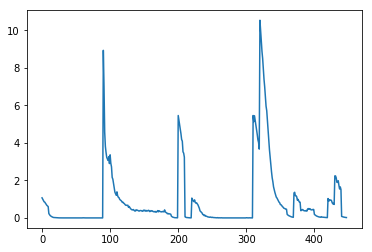

In [25]:
historydir = 'history'
with open(f'{historydir}/2019-12-01T223537Z.json') as fd:
    losshistory = json.load(fd)
    
plt.plot(losshistory) 

In [42]:
# so the above looks kind of symptomatic of non-shuffled data

#np.double(X[:2,:,:]) #
#model(np.double(X[:2,:,:]))
model(X.astype('float32'))


<tf.Tensor: id=5772693, shape=(7588, 4), dtype=float32, numpy=
array([[ 3.2522326, -2.3532636, -4.3805704, -1.4832745],
       [ 3.255394 , -2.3465173, -4.3836884, -1.4899037],
       [ 3.2746878, -2.3450208, -4.3617935, -1.4971757],
       ...,
       [ 3.3009374, -2.3251894, -4.407554 , -1.5297627],
       [ 3.2999878, -2.323608 , -4.4283414, -1.5353129],
       [ 3.2935128, -2.3350272, -4.4076843, -1.5382764]], dtype=float32)>

In [46]:
X.shape, Y.shape, Y[0]

((7588, 64, 8), (7588, 4), array([1., 0., 0., 0.]))

In [43]:
#how long does it take to just validate on the whole validation set...


1

In [49]:
preds = model(X.astype('float32'))


In [57]:
print(Y.shape, preds.numpy().shape)
labels = np.argmax(Y, axis=1)
print(Counter(labels))
tf.losses.sparse_softmax_cross_entropy(labels, preds.numpy()).numpy()

(7588, 4) (7588, 4)
Counter({0: 7588})


0.013968715

In [ ]:
# if i'm saving the train losses periodically,
# hmm I might as well save the model itself too so I can batch calculate validation losses too

In [58]:
%%time
# Given my datas, let's build a more uniform dataset... 

# Evaluate on the test data too..
counters_index = {}

for i in tqdm(range(56)): # test is 56

    with h5py.File('data/test.h5', 'r+') as fd:
        X = fd[f'dataset_{i}_X'].__array__()
        Y = fd[f'dataset_{i}_Y'].__array__()
        labels = np.argmax(Y, axis=1)
        counters_index[i] = dict(Counter(labels))



100%|██████████| 56/56 [00:15<00:00,  3.53it/s]

CPU times: user 552 ms, sys: 1.47 s, total: 2.02 s
Wall time: 15.9 s


In [59]:
counters_index

{0: {0: 117, 2: 9819},
 1: {2: 9936},
 2: {2: 9936},
 3: {2: 9936},
 4: {2: 9936},
 5: {2: 9936},
 6: {2: 9936},
 7: {2: 9936},
 8: {2: 9936},
 9: {2: 2069, 0: 7803},
 10: {3: 1776, 0: 8160},
 11: {3: 1950, 0: 7986},
 12: {0: 8655, 3: 1281},
 13: {0: 8655, 3: 1281},
 14: {0: 8655, 3: 1281},
 15: {0: 8368, 3: 1568},
 16: {0: 8655, 3: 1281},
 17: {0: 8655, 3: 1281},
 18: {0: 8591, 3: 1281},
 19: {0: 9936},
 20: {0: 6100, 1: 3836},
 21: {0: 9936},
 22: {0: 9936},
 23: {0: 9936},
 24: {0: 9936},
 25: {0: 6091, 1: 3845},
 26: {0: 9936},
 27: {0: 6495, 2: 3377},
 28: {2: 9936},
 29: {2: 9936},
 30: {2: 9936},
 31: {2: 9936},
 32: {2: 9936},
 33: {2: 9936},
 34: {2: 9936},
 35: {2: 9936},
 36: {2: 8493, 0: 1379},
 37: {0: 8655, 3: 1281},
 38: {0: 8655, 3: 1281},
 39: {0: 8655, 3: 1281},
 40: {0: 8655, 3: 1281},
 41: {0: 8156, 3: 1780},
 42: {0: 7238, 3: 2698},
 43: {0: 8655, 3: 1281},
 44: {0: 8158, 3: 1778},
 45: {0: 8655, 3: 1281},
 46: {0: 9872},
 47: {0: 9936},
 48: {0: 6091, 1: 3845},
 4

In [60]:
total_counts = {k: [x.get(k) for x in counters_index.values() 
                    if x.get(k) is not None]
               for k in [0,1,2,3]}

In [62]:
total_label_sums = {k: sum(total_counts[k]) for k in [0, 1, 2, 3]}


In [63]:
print(total_label_sums)

{0: 323937, 1: 15371, 2: 182734, 3: 26922}


In [70]:
labels[:5], preds.numpy()[:5]
print(':10', tf.losses.sparse_softmax_cross_entropy(labels[:10], preds.numpy()[:10]).numpy())
separately = [[[i, i+1], 
      tf.losses.sparse_softmax_cross_entropy(labels[i:i+1], preds.numpy()[i:i+1]).numpy()]
     for i in range(10)]
print('separately, ', separately)
print(np.mean([x[1] for x in separately]))

:10 0.012452257
separately,  [[[0, 1], 0.012856924], [[1, 2], 0.012782544], [[2, 3], 0.012494503], [[3, 4], 0.01218942], [[4, 5], 0.0121925995], [[5, 6], 0.0122052], [[6, 7], 0.012481787], [[7, 8], 0.012647891], [[8, 9], 0.012417033], [[9, 10], 0.012254659]]
0.012452257


In [83]:
X[[5,6,7],:].shape

(3, 64, 8)

In [152]:
# Ok indeed this looks like exactly uniformly weighted. ^^ 
# So since I know class 1 has the least examples, I'll use that as the minimum and add 
# this amount from each class , into a new file, 


#for i in range(56): # test is 56
#f'dataset_{i}_X', f'dataset_{i}_Y'
def read_h5(source_location, Xdataset, Ydataset):
    with h5py.File(source_location, 'r+') as fd:
        X = fd[Xdataset].__array__()
        Y = fd[Ydataset].__array__()
        Ylabels = np.argmax(Y, axis=1)
        counters_index[i] = dict(Counter(labels))
    return X, Ylabels

def read_h5_two(source_location, Xdataset, Ydataset):
    with h5py.File(source_location, 'r+') as fd:
        X = fd[Xdataset].__array__()
        Y = fd[Ydataset].__array__()
        #Ylabels = np.argmax(Y, axis=1)
        #counters_index[i] = dict(Counter(labels))
    return X, Y
        
    
def transfer_data(source_location,
                  source_datasets,
                 save_location,
                 label,
                 howmany):
    Xvec = []
    Ylabelvec = []
    # look for a certain amount of examples and transfer them to thew new location.
    sofar = 0
    for Xdataset, Ydataset in source_datasets:

        X, Ylabels = read_h5(source_location, Xdataset, Ydataset)
        indices = [i for i in range(Ylabels.shape[0])
                  if Ylabels[i] == label]
        if indices:
            X_a = X[indices, :]
            Ylabels_a = Ylabels[indices]
            Xvec.append(X_a)
            Ylabelvec.append(Ylabels_a)
            sofar += len(indices)
        
        if sofar >= howmany:
            print('ok breaking')
            break
    Xfull = np.concatenate(Xvec)
    Yfull = np.concatenate(Ylabelvec)
    save_that(save_location,
             f'X_{label}',
             Xfull)
    
    save_that(save_location,
             f'Ylabels_{label}',
             Yfull)
    print('Saved with ', Counter(Yfull))


def save_that(save_location, name, X):
    with h5py.File(save_location, "a") as f:
        f.create_dataset(name, data=np.array(X, dtype=float))


In [148]:
%%time
for k in [0, 1, 2, 3]:
    transfer_data(source_location='data/test.h5',
                               source_datasets=[[f'dataset_{i}_X', f'dataset_{i}_Y']
                                    for i in range(56)],
                 save_location='data/2019-12-07-test-balanced.h5',
                 label=k,
                 howmany=15371)

ok breaking
Saved with  Counter({0: 16080})
ok breaking
Saved with  Counter({1: 15371})
ok breaking
Saved with  Counter({2: 19755})
ok breaking
Saved with  Counter({3: 15542})
CPU times: user 1.19 s, sys: 3.09 s, total: 4.27 s
Wall time: 23.9 s


In [161]:
#tf.losses.sparse_softmax_cross_entropy
labels[:5], preds.numpy()[:5], labels.dtype
#print(':10', tf.losses.sparse_softmax_cross_entropy(labels[:10], preds.numpy()[:10]).numpy())
#separately = [[[i, i+1], 
#      tf.losses.sparse_softmax_cross_entropy(labels[i:i+1], preds.numpy()[i:i+1]).numpy()]
#     for i in range(10)]
#print('separately, ', separately)
#print(np.mean([x[1] for x in separately]))

(array([0, 0, 0, 0, 0]),
 array([[ 3.2522326, -2.3532636, -4.3805704, -1.4832745],
        [ 3.255394 , -2.3465173, -4.3836884, -1.4899037],
        [ 3.2746878, -2.3450208, -4.3617935, -1.4971757],
        [ 3.2986355, -2.3464212, -4.3506155, -1.4985747],
        [ 3.2941089, -2.3508587, -4.3722196, -1.5017868]], dtype=float32),
 dtype('int64'))

In [162]:
def get_performance(model, dataloc, dataset_names):
    # dataloc contains the test data..
    for Xdataset, Ydataset in dataset_names:

        X, Ylabels = read_h5_two(dataloc, Xdataset, Ydataset) 
    
        preds = model(X.astype('float32'))
        loss = tf.losses.sparse_softmax_cross_entropy(labels=Ylabels.astype('int64'),
                                               logits=preds.numpy()).numpy()
        print('loss', loss)

#with ipdb.launch_ipdb_on_exception():
get_performance(model=model, 
                dataloc='data/2019-12-07-test-balanced.h5',
                dataset_names=[['X_0', 'Ylabels_0'],
                              ['X_1', 'Ylabels_1'],
                              ['X_2', 'Ylabels_2'],
                              ['X_3', 'Ylabels_3']])

loss 3.2895672
loss 3.397873
loss 2.302168
loss 1.4254165


What a strange error.. because i didnt astype the labels to 'int64'

```python
InternalError: Could not find valid device for node.
Node: {{node SparseSoftmaxCrossEntropyWithLogits}}
All kernels registered for op SparseSoftmaxCrossEntropyWithLogits :
  device='XLA_CPU'; Tlabels in [DT_INT32, DT_INT64]; T in [DT_FLOAT, DT_DOUBLE, DT_BFLOAT16, DT_HALF]
  device='CPU'; T in [DT_HALF]; Tlabels in [DT_INT64]
  device='CPU'; T in [DT_HALF]; Tlabels in [DT_INT32]
  device='CPU'; T in [DT_DOUBLE]; Tlabels in [DT_INT64]
  device='CPU'; T in [DT_DOUBLE]; Tlabels in [DT_INT32]
  device='CPU'; T in [DT_FLOAT]; Tlabels in [DT_INT64]
  device='CPU'; T in [DT_FLOAT]; Tlabels in [DT_INT32]
  device='XLA_CPU_JIT'; Tlabels in [DT_INT32, DT_INT64]; T in [DT_FLOAT, DT_DOUBLE, DT_BFLOAT16, DT_HALF]
 [Op:SparseSoftmaxCrossEntropyWithLogits] name: xentropy

```

In [163]:
with h5py.File('data/train.h5', 'r+') as fd:
    print(list(fd.keys()))


['dataset_0_X', 'dataset_0_Y', 'dataset_10_X', 'dataset_10_Y', 'dataset_11_X', 'dataset_11_Y', 'dataset_12_X', 'dataset_12_Y', 'dataset_13_X', 'dataset_13_Y', 'dataset_14_X', 'dataset_14_Y', 'dataset_15_X', 'dataset_15_Y', 'dataset_16_X', 'dataset_16_Y', 'dataset_17_X', 'dataset_17_Y', 'dataset_18_X', 'dataset_18_Y', 'dataset_19_X', 'dataset_19_Y', 'dataset_1_X', 'dataset_1_Y', 'dataset_20_X', 'dataset_20_Y', 'dataset_21_X', 'dataset_21_Y', 'dataset_22_X', 'dataset_22_Y', 'dataset_23_X', 'dataset_23_Y', 'dataset_24_X', 'dataset_24_Y', 'dataset_25_X', 'dataset_25_Y', 'dataset_26_X', 'dataset_26_Y', 'dataset_27_X', 'dataset_27_Y', 'dataset_28_X', 'dataset_28_Y', 'dataset_29_X', 'dataset_29_Y', 'dataset_2_X', 'dataset_2_Y', 'dataset_30_X', 'dataset_30_Y', 'dataset_31_X', 'dataset_31_Y', 'dataset_32_X', 'dataset_32_Y', 'dataset_33_X', 'dataset_33_Y', 'dataset_34_X', 'dataset_34_Y', 'dataset_35_X', 'dataset_35_Y', 'dataset_36_X', 'dataset_36_Y', 'dataset_37_X', 'dataset_37_Y', 'dataset_38_X

In [164]:
# and what are the types in the train set..

# Evaluate on the test data too..
counters_index = {}

for i in tqdm(range(44)): # test is 56

    with h5py.File('data/train.h5', 'r+') as fd:
        X = fd[f'dataset_{i}_X'].__array__()
        Y = fd[f'dataset_{i}_Y'].__array__()
        labels = np.argmax(Y, axis=1)
        counters_index[i] = dict(Counter(labels))

total_counts = {k: [x.get(k) for x in counters_index.values() 
                    if x.get(k) is not None]
               for k in [0,1,2,3]}
total_label_sums = {k: sum(total_counts[k]) for k in [0, 1, 2, 3]}
print(total_label_sums)


100%|██████████| 44/44 [00:12<00:00,  3.53it/s]

{0: 226450, 1: 7625, 2: 179699, 3: 23090}


In [166]:
%%time
# ok... make train set...
# max 7625

for k in [0, 1, 2, 3]:
    transfer_data(source_location='data/train.h5',
                               source_datasets=[[f'dataset_{i}_X', f'dataset_{i}_Y']
                                    for i in range(56)],
                 save_location='data/2019-12-07-train-balanced.h5',
                 label=k,
                 howmany=7625)


ok breaking
Saved with  Counter({0: 9455})
ok breaking
Saved with  Counter({1: 7625})
ok breaking
Saved with  Counter({2: 8286})
ok breaking
Saved with  Counter({3: 8839})
CPU times: user 804 ms, sys: 2.42 s, total: 3.23 s
Wall time: 21.6 s


### 2019-12-08

In [168]:
# 
# Grab and randomize since it's not huge...
vecs = [read_h5_two(source_location='data/2019-12-07-train-balanced.h5', 
                    Xdataset=f'X_{i}',
                    Ydataset=f'Ylabels_{i}')
                 for i in [0, 1, 2, 3]]

X_test = np.concatenate([x[0] for x in vecs])
Ylabels_test = np.concatenate([x[1] for x in vecs])



MemoryError: 

Going to also try using this advice, retweeted here , https://mobile.twitter.com/ylecun/status/989610208497360896 , https://arxiv.org/abs/1804.07612 , _Friends dont let friends use minibatches larger than 32. _

In [ ]:
%%time 
# Use this new balanced trainset , for training..
loss_history = []
save_dir = 'history'

model = tf.keras.Sequential([
    tf.keras.layers.LSTM(64,   dropout=0.2, recurrent_dropout=0.2,
                batch_input_shape=(None, 64, 8), 
              ),
    # 4 because 'A', 'B', 'C', 'D'.
    tf.keras.layers.Dense(4)
])

class_weights = {0: 1., 1: 1., 2: 1., 3: 1.}

for i in tqdm(range(45)): # test is 56
    with h5py.File('data/train.h5', 'r+') as fd:
        X = fd[f'X_{i}'].__array__()
        Y = fd[f'Ylabels_{i}'].__array__()
    print(Counter([np.argmax(Y[i]) for i in range(Y.shape[0])]))
    training_indices = np.arange(0, X.shape[0], 1)
    dataset_batches = mu.build_dataset_weighty_v3(
            {'x_train': X, 'y_train': Y},
            training_indices, 
            class_weights,
            batch_size=1000)
    
    loss_history_this = mu.do_train(model, dataset_batches)
    loss_history_this = [float(x) for x in loss_history_this]
    loss_history.extend(loss_history_this)
    save_loss(loss_history, save_dir)